---
title: "Urban Population Data Analysis"

subtitle: "This notebook analyzes global urbanization trends, life expectancy, GDP per capita, and their relationships using data visualizations."

author: "Piyush Rajendra Jain"
student number: A00046344

course: "BAA1030: Data Analytics & Story Telling"
Professor: "Dr. Damien Dupre"

date: "2025-04-27"

format:
  html:
    embed-resources: true
    code-fold: true
    code-tools: false
    code-block-bg: true
    code-block-border-left: true
    code-summary: "Show the code"     
    toc: true
    toc-title: "On this page"          
    toc-depth: 3                      
    smooth-scroll: true                
    theme: cosmo                       
    highlight-style: github    
    self-contained: true

execute:
    echo: false                          
    warning: false                       
    message: false   
    output: true
    embed-resources: true                    

editor: visual

project:
  description: >
    This notebook analyzes global urbanization trends, GDP per capita, and life expectancy, using spatial maps, scatter plots, and correlation heatmaps to uncover relationships between urbanization and human development.
---



# **Explaining the Graphs: Urbanization, Wealth, and Life**
Let’s take a journey through urban development, global wealth, and human well-being — all using data visualization!

**Understanding the Modern World: Urbanization, Wealth, and Human Well-being**

The past decades have witnessed tremendous shifts in where and how humans live. **Urbanization** — the movement of humans from rural to urban areas — has fundamentally altered countries economically, socially, and even environmentally.

But urbanization is more than cities growing taller. It is intimately linked with economic prosperity and human well-being.
- Do richer countries urbanize more?
- Does city living really lead to a longer, healthier life?



In this project, we explore these questions by looking at global data on:

1.   Urban population percentages,
2.   GDP per capita, and
3.   Life expectancy


In a series of visualizations, we show how these powerful forces become intertwined to shape our world today.

In [70]:
#| echo: false
#| message: false
#| warning: false

# Importing all the required packages and libraries to efficiently complete the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from plotnine import *
import ipywidgets as widgets
from IPython.display import display
from shapely.geometry import Polygon

In [71]:
#| echo: false
#| message: false
#| warning: false

# Reading the csv uploaded to colab

urban_data = pd.read_csv('cleaned_unicef_data.csv')

In [72]:
#| echo: false
#| message: false
#| warning: false

# Dropping columns with more than 50% empty rows to make sure analysis is not skewed.

urban_df = urban_data.dropna(thresh=len(urban_data)*0.5, axis=1)

In [73]:
#| echo: false
#| message: false
#| warning: false

# Dropping empty rows from certain specific columns

urban_df = urban_df.dropna(subset=['life_expectancy_at_birth,_total_(years)', 'share_of_urban_population'])

In [74]:
#| echo: false
#| message: false
#| warning: false

# Imputing data in empty rows using mean

columns_to_fill = [
    'life_expectancy_at_birth,_total_(years)',
    'gdp_per_capita_(current_us$)',
    'gdp_per_capita_(constant_2015_us$)',
    'gni_(current_us$)',
    'inflation,_consumer_prices_(annual_%)',
    'birth_rate,_crude_(per_1,000_people)',
    'military_expenditure_(%_of_gdp)',
    'gdp_growth_(annual_%)'
]

for col in columns_to_fill:
    if col in urban_df.columns:
        urban_df[col].fillna(urban_df[col].mean(), inplace=True)


<ipython-input-74-c03e01e38ff3>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




**Graph 1: Choropleth Map of Urban Population Share**


Here is a world map tinted by the percentage of each country's population living in cities.

- Dark countries are highly urbanized (lots of people live in cities).
- Lighter ones, not so much.


This shows us from up high: Where are people aggregating in cities? Which places are still quite rural?

But urbanization is not a lone activity. It touches life — sometimes subtly, sometimes fundamentally.
So naturally we ask:

"*Do urban living really improve your quality of life?*"

To explore that......


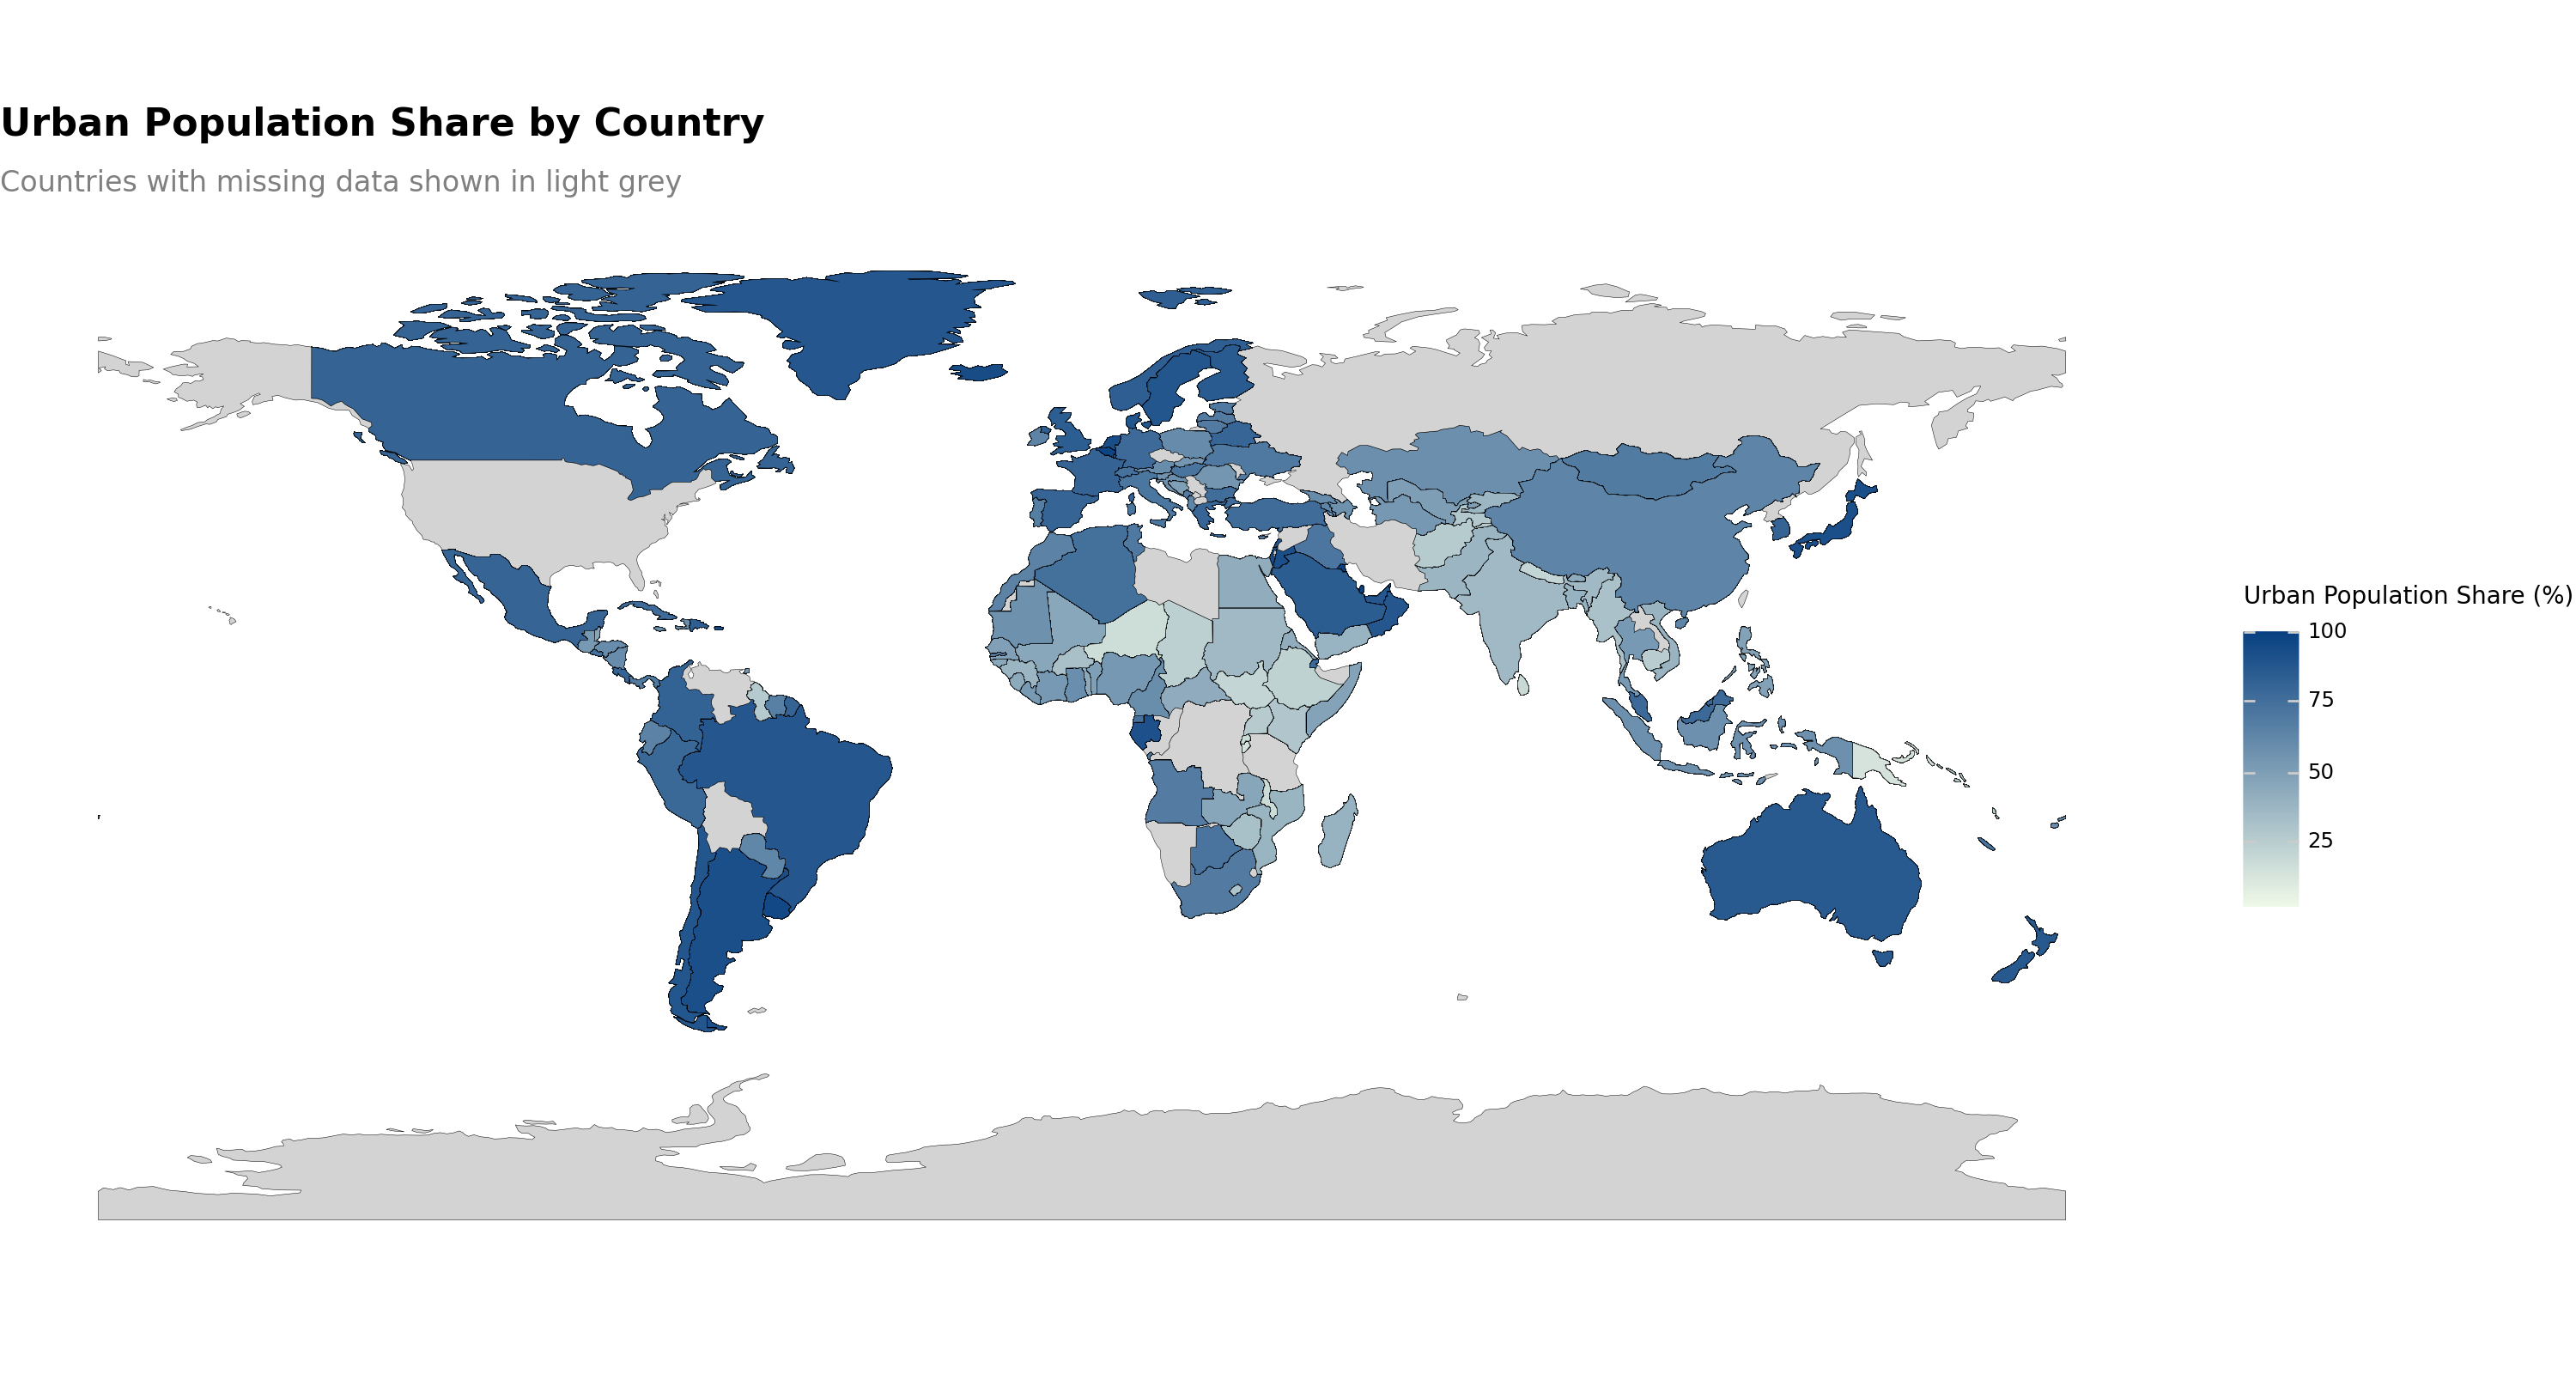

In [75]:
#| echo: true
#| message: false
#| warning: false

!wget -q https://github.com/nvkelso/natural-earth-vector/raw/master/geojson/ne_110m_admin_0_countries.geojson -O countries.geojson

# 🗺️ Load world country shapes
map_data = gpd.read_file("countries.geojson")
map_data.rename(columns={'ADMIN': 'country'}, inplace=True)

# 🔗 Merge world map with urban population data
merged = pd.merge(map_data, urban_df[['country', 'share_of_urban_population']], on='country', how='left')

# 🧹 Clean geometries
map_df = merged.explode(index_parts=False).reset_index(drop=True)
map_df = map_df[map_df['geometry'].notnull() & map_df['geometry'].apply(lambda g: g.geom_type == 'Polygon')]

# 🔄 Convert polygons to coordinate points for plotnine
def extract_coords(row):
    x, y = row.geometry.exterior.coords.xy
    return pd.DataFrame({
        'x': x,
        'y': y,
        'country': row['country'],
        'share_of_urban_population': row['share_of_urban_population'],
        'group': row.name  # unique ID for each shape
    })

plot_df = pd.concat([extract_coords(row) for _, row in map_df.iterrows()], ignore_index=True)

# 📈 Create choropleth map with plotnine
world_map = (
    ggplot(plot_df, aes(x='x', y='y', group='group', fill='share_of_urban_population')) +
    geom_polygon(color='black', size=0.1) +
    scale_fill_gradient(
        low="#f0f9e8", high="#084081",
        name="Urban Population Share (%)",
        na_value="lightgrey"
    ) +
    coord_equal() +
    theme_void() +
    labs(
        title="Urban Population Share by Country",
        subtitle="Countries with missing data shown in light grey"
    ) +
    theme(
        figure_size=(15, 8),
        plot_title=element_text(size=16, weight='bold'),
        plot_subtitle=element_text(size=12, color='gray'),
        legend_title=element_text(size=10),
        legend_position='right'
    ))

display(world_map)


**Graph 2: Top 10 Countries by Life Expectancy (2020)**

We shift our focus to **life expectancy — an important measure of well-being.**

This **bar chart** shows the **10** countries with the **highest life expectancy** in 2020.
We can start spotting a pattern: many of these countries are also highly urbanized, suggesting a potential link.

But just looking at the top countries isn’t enough. We need to see the **relationship across the whole world.**

<ipython-input-76-84761551366d>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



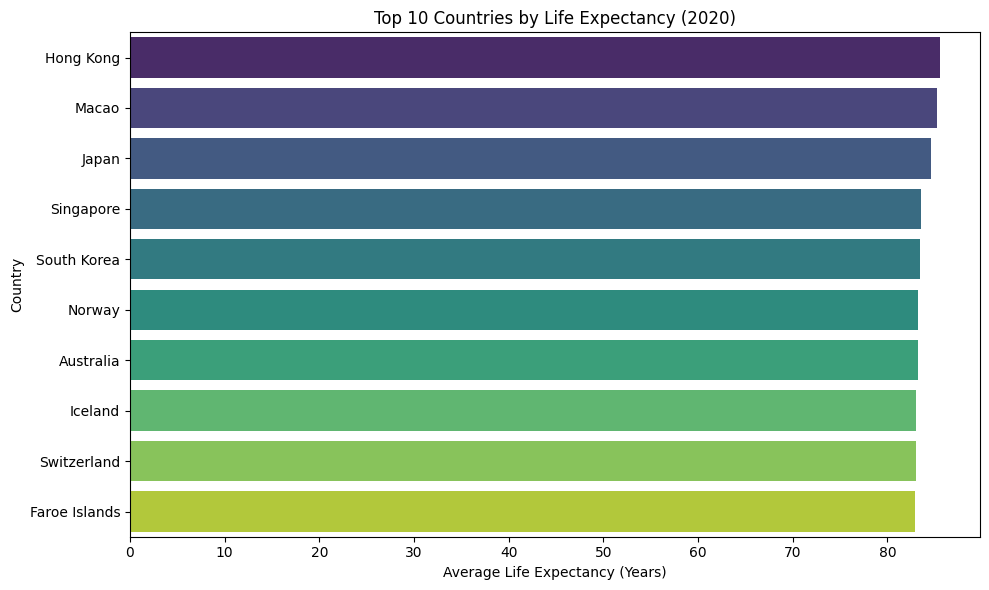

In [76]:
#| echo: true
#| message: false
#| warning: false


# Filter for 2020
data_2020 = urban_df[urban_df['year'] == 2020].dropna(subset=['life_expectancy_at_birth,_total_(years)'])

# Group by country and calculate mean life expectancy
avg_lifeexp = (
    data_2020.groupby("country")["life_expectancy_at_birth,_total_(years)"]
    .mean()
    .reset_index(name="avg_life_expectancy")
)

# Get top 10 countries with highest life expectancy
top10 = avg_lifeexp.nlargest(10, "avg_life_expectancy")

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=top10, y="country", x="avg_life_expectancy", palette="viridis")
plt.title("Top 10 Countries by Life Expectancy (2020)")
plt.xlabel("Average Life Expectancy (Years)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


**Graph 3: Scatter Plot - Urban Population vs Life Expectancy**

Here, every point represents a country.
We plot **urbanization on the x-axis** and **life expectancy on the y-axis.**

The trend line shows us:
- More urbanized countries tend to have higher life expectancies!

It’s not a perfect correlation, but the positive relationship is clear.

At this point, we realize wealth might be a hidden player in this story.
So we ask:

> "*Maybe richer countries are both more urbanized and healthier*?"



To dig deeper...

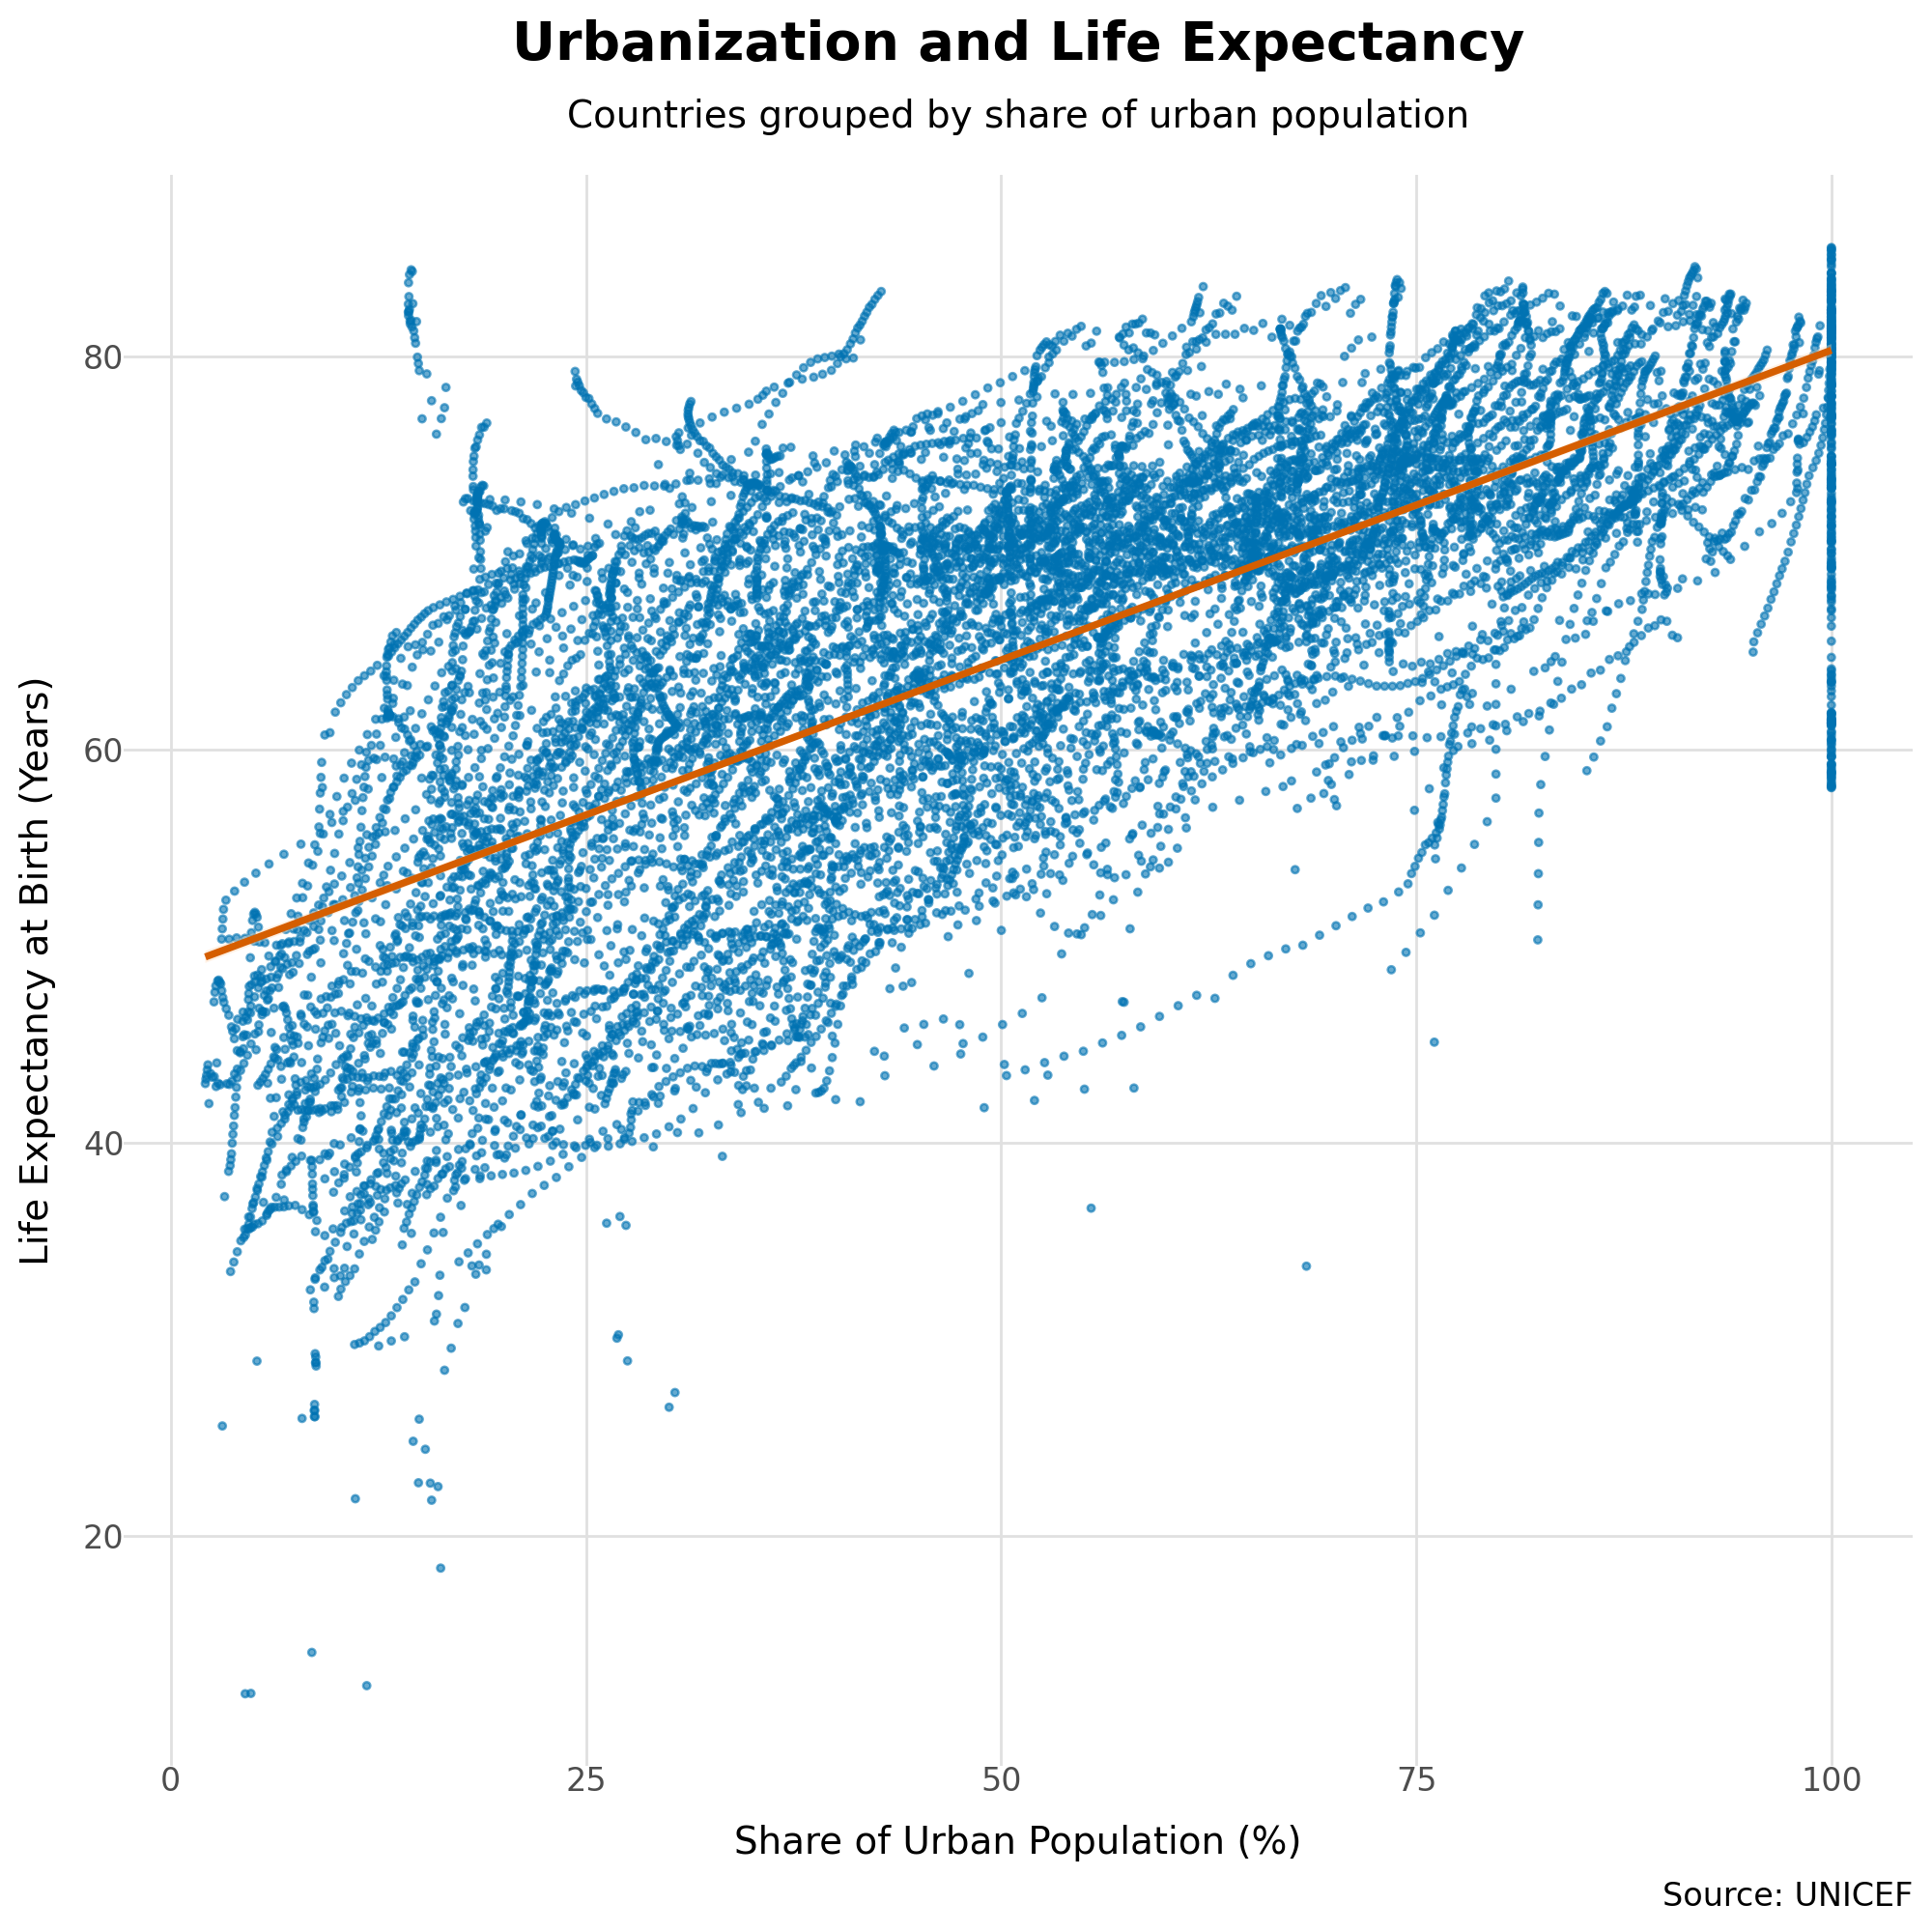

In [77]:
#| echo: true
#| message: false
#| warning: false

scatter_plot = (
    ggplot(urban_df, aes(x='share_of_urban_population', y='life_expectancy_at_birth,_total_(years)')) +
    geom_point(
        color="#0072B2",
        size=1,
        alpha=0.6
    ) +
    geom_smooth(
        method='lm',
        color="#D55E00",
        linetype="solid",
        size=1.5,
        se=True,
        fill="#FFDAB9"
    ) +
    labs(
        title='Urbanization and Life Expectancy',
        subtitle='Countries grouped by share of urban population',
        x='Share of Urban Population (%)',
        y='Life Expectancy at Birth (Years)',
        caption='Source: UNICEF'
    ) +
    theme_minimal(base_size=15) +
    theme(
        plot_title=element_text(weight='bold', size=20, ha='center', margin={'b': 10}),
        plot_subtitle=element_text(size=14, ha='center', margin={'b': 15}),
        axis_title_x=element_text(size=14, margin={'t': 10}),
        axis_title_y=element_text(size=14, margin={'r': 10}),
        axis_text=element_text(size=12),
        panel_grid_major=element_line(color='#e0e0e0'),
        panel_grid_minor=element_blank(),
        figure_size=(10, 10)
    )
)

display(scatter_plot)


**Graph 4: Correlation Heatmap**

This colorful heatmap shows correlations between different variables:

- Urbanization

- GDP per capita

- Life expectancy

Strong positive or negative colors highlight where **tight relationships** exist.
This gives us a **bird’s-eye view** of how all these factors interact!

Finally, we tie everything back to our original hypothesis...

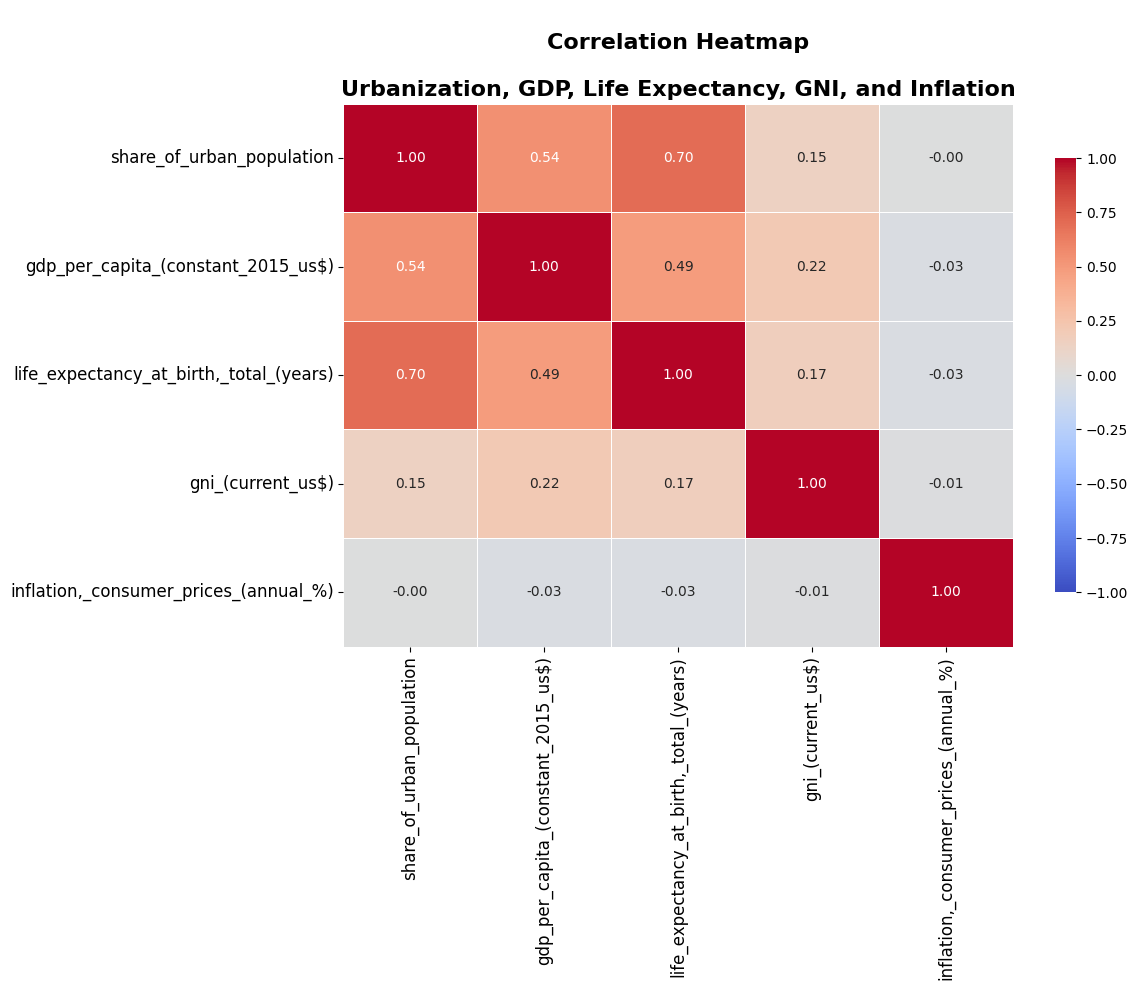

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_data = urban_df[[
    'share_of_urban_population',
    'gdp_per_capita_(constant_2015_us$)',
    'life_expectancy_at_birth,_total_(years)',
    'gni_(current_us$)',
    'inflation,_consumer_prices_(annual_%)'
]]

# Calculate the correlation matrix
corr_matrix = corr_data.corr()
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)

# Titles
plt.title('\nCorrelation Heatmap\n\nUrbanization, GDP, Life Expectancy, GNI, and Inflation', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()


**Graph 5: Urban Population Trends Over Time**

This line graph shows urban growth from **2000 to 2020**.

- A clear **upward trend** proves that **urbanization is increasing globally**, year after year.

Now that we’ve seen urbanization, health, and wealth separately,
we want to see how all **factors are related to each other at once.**

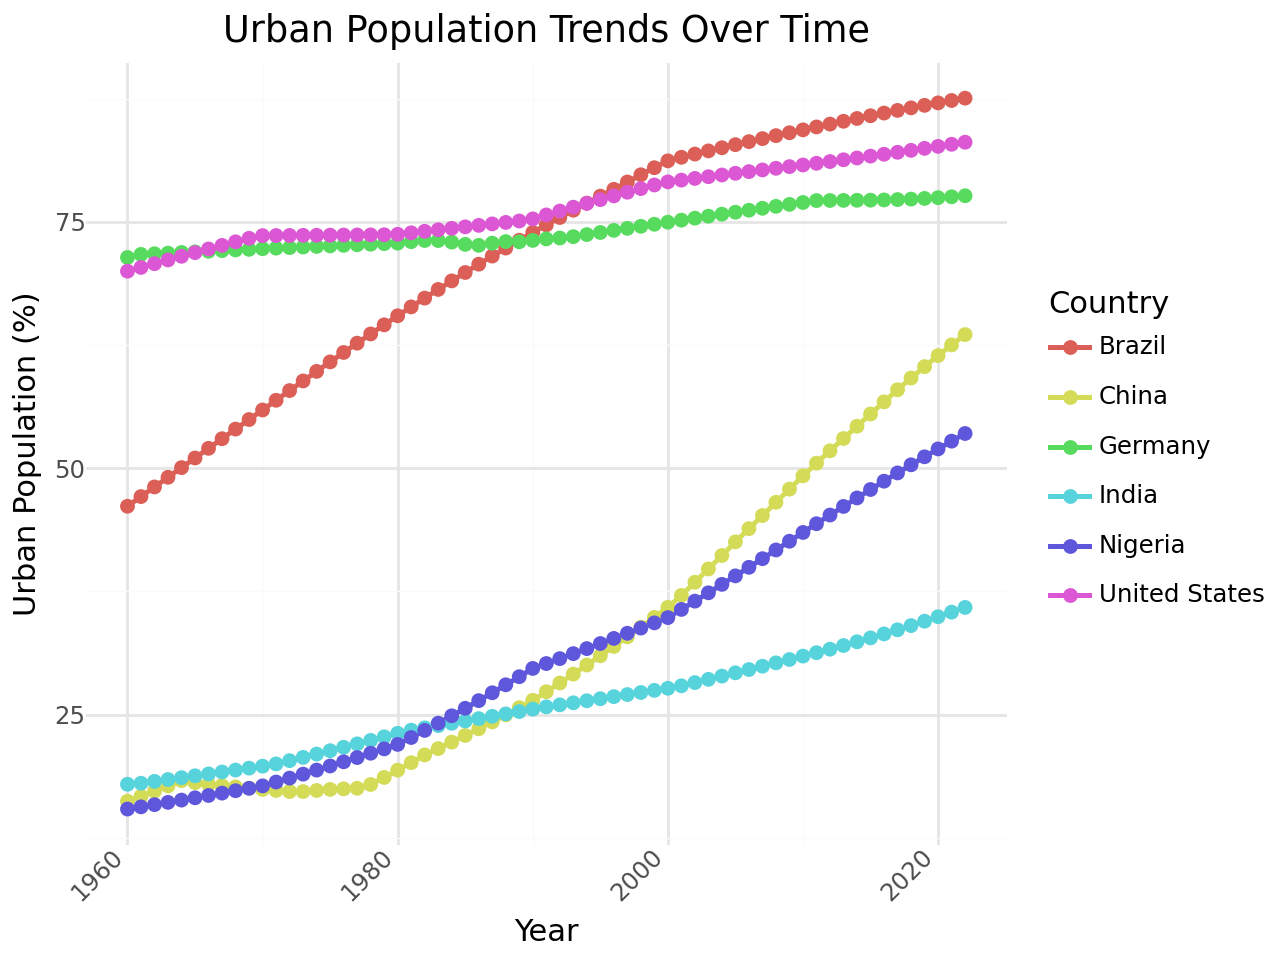

In [79]:

#| echo: true
#| message: false
#| warning: false

# Choose representative countries
countries = ['United States', 'China', 'India', 'Brazil', 'Nigeria', 'Germany']
time_data = urban_df[urban_df['country'].isin(countries)]

# Sort to ensure smooth lines
time_data = time_data.sort_values(by=['country', 'year'])

# Time series plot
time_series_plot = (
    ggplot(time_data, aes(x='year', y='share_of_urban_population', color='country')) +
    geom_line(size=1) +
    geom_point(size=2) +
    labs(title='Urban Population Trends Over Time',
         x='Year',
         y='Urban Population (%)',
         color='Country') +
    theme_minimal() +
    theme(axis_text_x=element_text(angle=45, hjust=1))
)

display(time_series_plot)


# **CONCLUSION:**

Key Takeaways:

Our visual journey reveals several important insights:

- Urbanization is unevenly distributed across the globe, but it’s steadily rising everywhere.

- Countries with higher urban populations tend to enjoy longer life expectancies, suggesting better access to healthcare, education, and services.

- Economic prosperity (GDP per capita) is strongly linked to both urbanization and life expectancy.




Wealthier, more urbanized nations generally offer better living standards for their populations.

Together, the data paints a clear picture:
**Urbanization, when combined with economic development, can be a powerful driver of better human outcomes.**

However, the benefits are not automatic — thoughtful planning, inclusivity, and sustainability are crucial to ensuring that urban growth leads to a healthier and more equitable world for all.